In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

In [4]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 224

def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in tqdm(os.listdir(path)):
            try:
                # Load and resize the image
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize the image

                # Add the image and label as a pair
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    # Convert the list to a NumPy array
    data = np.array(data, dtype=object)  # Use dtype=object to allow image-label pairing
    return data

# get relativ Path of the data
current_dir = os.getcwd()  # current directory
norm_data_dir = os.path.join(current_dir, "../..", "normData") 

# lead the data
test_data = get_training_data(os.path.join(norm_data_dir, "test"))
train_data = get_training_data(os.path.join(norm_data_dir, "train"))
val_data = get_training_data(os.path.join(norm_data_dir, "val"))

100%|██████████| 108/108 [00:00<00:00, 1231.16it/s]


In [5]:
# Function to normalize the images
def normalize_images(data):
    images = []
    labels = []

    for img, label in tqdm(data):
        # Normalization: each pixel is divided by 255
        normalized_img = img / 255.0
        images.append(normalized_img)
        labels.append(label)

    # Convert the images and labels into separate arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Normalize the images in the training dataset
train_images, train_labels = normalize_images(train_data)
val_images, val_labels = normalize_images(val_data)
test_images, test_labels = normalize_images(test_data)


# Check the shape and an example of the normalized and shuffled data
print(f"Shape of normalized and shuffled train images: {test_images.shape}")
print(f"Shape of normalized and shuffled train images: {train_images.shape}")
print(f"Shape of normalized and shuffled validation images: {val_images.shape}")

100%|██████████| 624/624 [00:00<00:00, 2889.66it/s]

Shape of normalized and shuffled train images: (624, 224, 224)
Shape of normalized and shuffled train images: (7550, 224, 224)
Shape of normalized and shuffled validation images: (216, 224, 224)


In [6]:
class ResNet(nn.Module):
    def __init__(self, num_classes=2, softmax=True):
      super(ResNet, self).__init__()
      self.resnet = torchvision.models.resnet18(pretrained=True)
      num_ftrs = self.resnet.fc.out_features
      self.fc = nn.Linear(num_ftrs, num_classes)
      self.bn = nn.BatchNorm1d(num_ftrs)
      self.relu = nn.ReLU()
      self.softmax = torch.nn.Softmax(dim=1) if softmax else None
      self.change_conv1()

    def forward(self, x):
      x = self.resnet(x)
      x = self.bn(x)
      x = self.relu(x)
      x = self.fc(x)
      if self.softmax:
        x = self.softmax(x)
      return x

    def change_conv1(self):
      original_conv1 = self.resnet.conv1

      #Create a new convolutional layer with 1 input channel instead of 3
      new_conv1 = nn.Conv2d(
        in_channels=1,  # Grayscale has 1 channel
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias is not None
)

      # Initialize the new conv layer's weights by averaging the RGB weights
      with torch.no_grad():
        new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))

        #Replace the original conv1 with the new one
        self.resnet.conv1 = new_conv1


model = ResNet(num_classes=2, softmax=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)




/Users/mark/miniconda3/envs/bkimpr/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mark/miniconda3/envs/bkimpr/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu


In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Convert the images and labels to PyTorch tensors

# Apply the transformation to training and validation images
train_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in train_images]).unsqueeze(1)
val_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in val_images]).unsqueeze(1)

# Now permute them
train_images_tensor = train_images_tensor.permute(0, 1, 2, 3)  # (N, 1, 244, 244)
val_images_tensor = val_images_tensor.permute(0, 1, 2, 3)      # (N, 1, 244, 244)
print(val_images_tensor.shape, train_images_tensor.shape)

# The tensors are now in the shape (N, 1, 244, 244), where N is the number of images

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)

# Define the batch size
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
print('Done!')



torch.Size([216, 1, 224, 224]) torch.Size([7550, 1, 224, 224])
Done!


### **Training**

In [8]:
from sklearn.metrics import classification_report

# Define params
learning_rate = 0.0001
batch_size = 32
weight_decay = 1e-6

criterion = nn.CrossEntropyLoss() 
train_loader = DataLoader(
                train_dataset, batch_size=batch_size, shuffle=True
            )

optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

# Training function with logging
def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10
):
    patience_counter = 0
    best_validation_score = 0

    # lists for logging
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        p_bar = tqdm(train_loader)
        running_loss = 0
        all_train_preds = []
        all_train_labels = []

        for i, (images, labels) in enumerate(p_bar):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # log the training metrics
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

            p_bar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss / (i + 1)}"
            )

        # log the training loss and metrics
        train_losses.append(running_loss / len(train_loader))
        train_class_report = classification_report(
            all_train_labels,
            all_train_preds,
            target_names=["Pneumonia", "Normal"],
            output_dict=True,
        )
        train_f1_scores.append(train_class_report["weighted avg"]["f1-score"])
        train_accuracies.append(train_class_report["accuracy"])

        # validation
        model.eval()
        p_bar = tqdm(val_loader)
        all_preds = []
        all_labels = []
        val_running_loss = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(p_bar):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                p_bar.set_description(
                    f"Epoch {epoch+1}/{num_epochs} - Validation Batch: {i}"
                )

        # log the validation metrics
        val_losses.append(val_running_loss / len(val_loader))
        class_report = classification_report(
            all_labels,
            all_preds,
            target_names=["Pneumonia", "Normal"],
            output_dict=True,
        )
        val_f1_scores.append(class_report["weighted avg"]["f1-score"])
        val_accuracies.append(class_report["accuracy"])

        print(
            f"Epoch {epoch+1}/{num_epochs} - "
            f"Train Loss: {train_losses[-1]:.4f}, Train F1: {train_f1_scores[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
            f"Val Loss: {val_losses[-1]:.4f}, Val F1: {val_f1_scores[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}"
        )

        # Early Stopping
        if val_f1_scores[-1] > best_validation_score:
            best_validation_score = val_f1_scores[-1]
            patience_counter = 0
            # torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/model_results', 'best_model_resnet.pth'))
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return (
        train_losses,
        val_losses,
        train_f1_scores,
        val_f1_scores,
        train_accuracies,
        val_accuracies,
    )


# 
(
    train_losses,
    val_losses,
    train_f1_scores,
    val_f1_scores,
    train_accuracies,
    val_accuracies,
) = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=5,
    patience=10,
)

Epoch 1/5 - Validation Batch: 26: 100%|██████████| 27/27 [00:04<00:00,  6.47it/s]


Epoch 1/5 - Train Loss: 0.3487, Train F1: 0.9702, Train Acc: 0.9702, Val Loss: 0.4225, Val F1: 0.8875, Val Acc: 0.8889


Epoch 2/5 - Validation Batch: 26: 100%|██████████| 27/27 [00:04<00:00,  5.80it/s]


Epoch 2/5 - Train Loss: 0.3252, Train F1: 0.9890, Train Acc: 0.9890, Val Loss: 0.3317, Val F1: 0.9815, Val Acc: 0.9815


Epoch 3/5 - Validation Batch: 26: 100%|██████████| 27/27 [00:04<00:00,  6.19it/s]


Epoch 3/5 - Train Loss: 0.3211, Train F1: 0.9928, Train Acc: 0.9928, Val Loss: 0.3305, Val F1: 0.9815, Val Acc: 0.9815


Epoch 4/5 - Validation Batch: 26: 100%|██████████| 27/27 [00:04<00:00,  6.23it/s]


Epoch 4/5 - Train Loss: 0.3198, Train F1: 0.9943, Train Acc: 0.9943, Val Loss: 0.3312, Val F1: 0.9815, Val Acc: 0.9815


Epoch 5/5 - Validation Batch: 26: 100%|██████████| 27/27 [00:04<00:00,  5.60it/s]

Epoch 5/5 - Train Loss: 0.3171, Train F1: 0.9966, Train Acc: 0.9966, Val Loss: 0.3362, Val F1: 0.9815, Val Acc: 0.9815


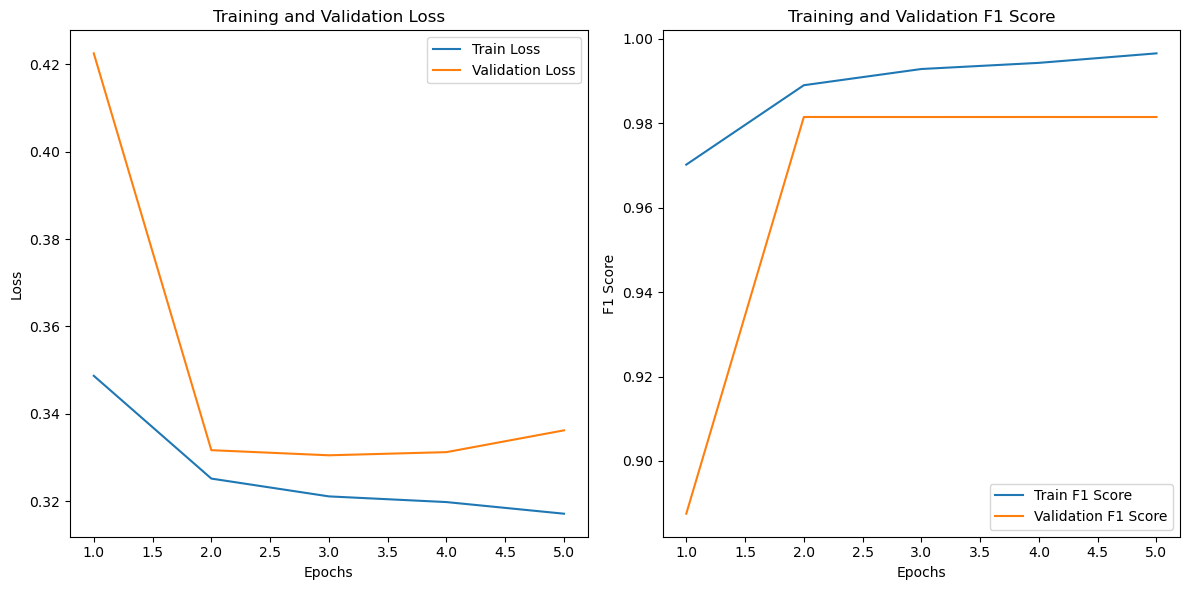

In [9]:
import matplotlib.pyplot as plt

# Plotting
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot f1-Score
plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1_scores, label="Train F1 Score")
plt.plot(epochs, val_f1_scores, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()

# Plot accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### **Testing**

In [ ]:
state_dict = torch.load('/content/drive/MyDrive/model_results/best_model_resnet.pth')
model.load_state_dict(state_dict)

In [ ]:
test_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in test_images]).unsqueeze(1)  # Applying the same transformation as for train/val
test_images_tensor = test_images_tensor.permute(0, 1, 2, 3)
print(test_images_tensor.shape)

test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)  # or torch.float if binary classification

# Create the dataset and DataLoader for the test set
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

all_predictions = []
all_labels = []
for images, labels in test_loader:
  images, labels = images.to(device), labels
  outputs = model(images)
  _, preds = torch.max(outputs, 1)
  all_predictions.extend(preds.cpu().numpy())
  all_labels.extend(labels.numpy())

class_report = classification_report(all_labels, all_predictions, target_names=['NORMAL', 'PNEUMONIA'])
print(class_report)

